[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyPartMC/blob/main/examples/mie_optical.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/mie_optical.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/mie_optical.ipynb)    
[![ARM JupyterHub](https://img.shields.io/static/v1?label=launch%20in&logo=jupyter&color=lightblue&message=ARM+JupyterHub)](https://jupyterhub.arm.gov/hub/user-redirect/git-pull?repo=https%3A//github.com/open-atmos/PyPartMC&branch=main&urlPath=) (requires [logging in with ARM account](https://www.arm.gov/capabilities/computing-resources) and directing Jupyter to a notebook within the cloned repo)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
import sys
import os
if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC', 'PyMieScatt')
elif 'JUPYTER_IMAGE' in os.environ and '.arm.gov' in os.environ['JUPYTER_IMAGE']:
    !pip --quiet install PyPartMC PyMieScatt open_atmos_jupyter_utils
    _pypartmc_path = !pip show PyPartMC | fgrep Location | cut -f2 -d' '
    sys.path.extend(_pypartmc_path if _pypartmc_path[0] not in sys.path else [])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# https://pymiescatt.readthedocs.io/en/latest/ and https://github.com/bsumlin/PyMieScatt
import PyMieScatt as ps
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

In [4]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (3.08,2.5)})
plt.rcParams.update({"axes.grid" : True})

In [5]:
def aero_state_compute_optical(aero_state_optical):
    wl = 550.0 # unit: nm
    refr_shell = 1.52+0*1j
    refr_core = 1.82+0.74*1j
    diams_core = np.array(aero_state_optical.diameters(include=["BC"])) * 1e9 # unit: nm
    diams_total = np.array(aero_state_optical.diameters()) * 1e9 # unit: nm
    
    qsca_part = np.zeros(len(aero_state_optical))
    qabs_part = np.zeros(len(aero_state_optical))
    for i_part in range(len(aero_state_optical)):
        val = ps.MieQCoreShell(refr_core,
                               refr_shell,
                               wl,
                               diams_core[i_part],
                               diams_total[i_part],
                               asDict=True
                              )
        qsca_part[i_part] = val['Qsca']
        qabs_part[i_part] = val['Qabs']
        
    cross_section = np.pi * (diams_total / 2 / 1e9)**2
    
    num_concs = aero_state_optical.num_concs
    B_abs = np.sum(qabs_part * cross_section * num_concs)
    B_sca = np.sum(qsca_part * cross_section * num_concs)

    return (diams_total, qsca_part, qabs_part, B_sca, B_abs)

In [6]:
gas_data = ppmc.GasData(("H2SO4","HNO3","HCl","NH3","NO","NO2", "NO3",
                        "N2O5", "HONO", "HNO4", "O3", "O1D", "O3P", "OH",
                        "HO2", "H2O2", "CO", "SO2", "CH4", "C2H6", "CH3O2", 
                        "ETHP", "HCHO", "CH3OH", "ANOL", "CH3OOH", "ETHOOH",
                        "ALD2", "HCOOH", "RCOOH", "C2O3", "PAN", "ARO1", "ARO2",
                        "ALK1", "OLE1", "API1", "API2", "LIM1", "LIM2", "PAR", "AONE",
                        "MGLY", "ETH", "OLET", "OLEI", "TOL", "XYL", "CRES", "TO2",
                         "CRO", "OPEN", "ONIT", "ROOH", "RO2", "ANO2", "NAP", "XO2",
                         "XPAR", "ISOP", "ISOPRD", "ISOPP", "ISOPN", "ISOPO2", "API",
                         "LIM", "DMS", "MSA", "DMSO", "DMSO2", "CH3SO2H", "CH3SCH2OO", 
                         "CH3SO2", "CH3SO3", "CH3SO2OO", "CH3SO2CH2OO", "SULFHOX"
                        ))

In [7]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": 0.95,
        "latitude": 0,
        "longitude": 0,
        "altitude": 0 * si.m,
        "start_time": 21600 * si.s,
        "start_day": 200,
    }
)

In [8]:
aero_data = ppmc.AeroData(
    (
        #         density  ions in soln (1) molecular weight    kappa (1)
        #         |                     |   |                   |
        {"SO4": [1800 * si.kg / si.m**3, 1, 96.0 * si.g / si.mol, 0.00]},
        {"NO3": [1800 * si.kg / si.m**3, 1, 62.0 * si.g / si.mol, 0.00]},
        {"Cl": [2200 * si.kg / si.m**3, 1, 35.5 * si.g / si.mol, 0.00]},
        {"NH4": [1800 * si.kg / si.m**3, 1, 18.0 * si.g / si.mol, 0.00]},
        {"MSA": [1800 * si.kg / si.m**3, 0, 95.0 * si.g / si.mol, 0.53]},
        {"ARO1": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ARO2": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ALK1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"OLE1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"API1": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"API2": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"LIM1": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"LIM2": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"CO3": [2600 * si.kg / si.m**3, 1, 60.0 * si.g / si.mol, 0.00]},
        {"Na": [2200 * si.kg / si.m**3, 1, 23.0 * si.g / si.mol, 0.00]},
        {"Ca": [2600 * si.kg / si.m**3, 1, 40.0 * si.g / si.mol, 0.00]},
        {"OIN": [2600 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.10]},
        {"OC": [1400 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.10]},
        {"BC": [1800 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.00]},
        {"H2O": [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol, 0.00]},
    )
)

In [9]:
gas_state = ppmc.GasState(gas_data)

input_gas_state = (
    {"NO": [0.1E+00]},
)

gas_state.mix_rats = input_gas_state

In [10]:
times = [0 * si.s]
back_gas = [{"time": times},
            {"rate": [1.5e-5 / si.s]},
            {"NO": [0.1E+00]},
           ]

gas_emit_times = [0, 3600, 7200, 10800, 14400, 18000, 21600, 25200, 28800, 32400, 36000,
                  39600, 43200, 46800, 50400, 54000, 57600, 61200, 64800, 68400, 72000,
                  75600, 79200, 82800, 90000, 93600, 97200, 100800, 104400, 108000]

gas_emit_rates = np.zeros(len(gas_emit_times))
gas_emit_rates[0:12] = .5

SO2 = [4.234E-09, 5.481E-09, 5.089E-09, 5.199E-09, 5.221E-09, 5.284E-09, 5.244E-09,
       5.280E-09, 5.560E-09, 5.343E-09, 4.480E-09, 3.858E-09, 3.823E-09, 3.607E-09,
       3.533E-09, 3.438E-09, 2.866E-09, 2.667E-09, 2.636E-09, 2.573E-09, 2.558E-09,
       2.573E-09, 2.715E-09, 3.170E-09, 4.2344E-09, 5.481E-09, 5.089E-09, 5.199E-09,
       5.221E-09, 5.284E-09]

emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"SO2": SO2},
]

AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 3.2e9 / si.m**3,
        "geom_mean_diam": 0.02 * si.um,
        "log10_geom_std_dev": 0.161,
    },
    "back_large": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 2.9e9 / si.m**3,
        "geom_mean_diam": 0.16 * si.um,
        "log10_geom_std_dev": 0.217,
    },
}

AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"OC": [0.8]}, {"BC": [0.2]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 5e7 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
    "diesel": {
        "mass_frac": [{"OC": [0.3]}, {"BC": [0.7]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 1.6e8 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
    "cooking": {
        "mass_frac": [{"OC": [1]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 9e6 / si.m**3,
        "geom_mean_diam": 8.64e-8 * si.m,
        "log10_geom_std_dev": 0.28,
    },
}

In [11]:
time_timeseries = list(np.linspace(0,24*3600,25))
pressure_timeseries = list(np.ones(25) * 1e5)
temp_timeseries = [290.016,292.5, 294.5, 296.112, 297.649, 299.049, 299.684, 299.509,299.002,
                   298.432, 296.943, 295.153, 293.475, 292.466, 291.972, 291.96, 291.512,
                   291.481, 290.5,   290.313, 290.317, 290.362, 290.245, 290.228, 291.466]
height_timeseries = [171.045, 228.210, 296.987, 366.002, 410.868, 414.272, 417.807,414.133,
                     397.465, 376.864, 364.257, 352.119, 338.660, 322.028, 305.246, 258.497,  
                     240.478, 187.229, 145.851, 128.072, 110.679, 97.628, 93.034, 93.034, 93.034]

In [12]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * si.s, 12 * 3600 * si.s]},
            {"rate": [1 / si.s, 0 / si.s]},
            {"dist": [[AERO_DIST_EMIT],[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * si.s]},
            {"rate": [1.5e-5 / si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        "loss_function": "none",
    },
)

In [13]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

AERO_DIST_INIT = [
    {
        "init_small": {
            "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 3.2e9 / si.m**3,
            "geom_mean_diam": 0.02 * si.um,
            "log10_geom_std_dev": 0.161,
        },
        "init_large": {
            "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 2.9e9 / si.m**3,
            "geom_mean_diam": 0.16 * si.um,
            "log10_geom_std_dev": 0.217,
        },
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": "urban_plume",
        "do_coagulation": True,
        "coag_kernel": "brown",
        "t_max": 24 * 3600 * si.s,
        "del_t": 60 * si.s,
    }
)

N_PART = 1000
aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
n_added = aero_state.dist_sample(
    aero_dist_init,
    sample_prop=1.0,
    create_time=0.0,
    allow_doubling=True,
    allow_halving=True,
)
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

In [14]:
N_BLOCKS = int(run_part_opt.t_max / 3600)
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
N_STEPS_PER_BLOCK = int(N_STEPS / N_BLOCKS)
Bsca = np.zeros(N_BLOCKS+1)
Babs = np.zeros(N_BLOCKS+1)
time = np.zeros(N_BLOCKS+1)
i_time = 1
i_output = 1
last_output_time = 0.
last_progress_time = 0.
diameters, qsca, qabs, Bsca[0], Babs[0] = aero_state_compute_optical(aero_state)

for i_block in range(1,N_BLOCKS+1):
    i_next = int(N_STEPS_PER_BLOCK * i_block)
    (last_output_time, last_progress_time, i_output) = ppmc.run_part_timeblock(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        i_next,
        0,
        last_output_time,
        last_progress_time,
        i_output
    )
    time[i_block] = env_state.elapsed_time
    diameters, qsca, qabs, Bsca[i_block], Babs[i_block] = aero_state_compute_optical(aero_state)
    i_time = i_next + 1

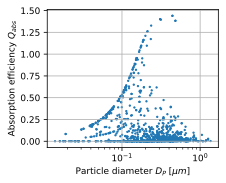

HTML(value="<a href='./tmpwa8h81i9.pdf' target='_blank'>./tmpwa8h81i9.pdf</a><br>")

In [15]:
plt.scatter(diameters * 1e-3, qabs, s=2)
plt.ylabel(r"Absorption efficiency $Q_{abs}$")
plt.xlabel(r"Particle diameter $D_P\;[\mu m]$")
plt.xscale('log')
show_plot()

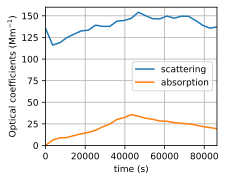

HTML(value="<a href='./tmp0ssq943b.pdf' target='_blank'>./tmp0ssq943b.pdf</a><br>")

In [16]:
plt.plot(time, Bsca * 1e6, label=r'scattering')
plt.plot(time, Babs * 1e6, label=r'absorption')
plt.ylabel(r"Optical coefficients (Mm$^{-1}$)")
plt.xlabel(r"time (s)")
plt.xlim([0,24*3600])
plt.ylim([0,160])
plt.legend()
show_plot()